In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def u(x, y, a_1, b_1):
    numerator = a_1 * y
    denominator = 1/(1 + b_1 * x)
    fraction = numerator * denominator
    return x * (2 - x - fraction)


def v(x_new, y, z, a_1, a_2, b_1, b_2, d_1):
    numerator_x = a_1 * x_new
    denominator_x = 1/(1 + b_1 * x_new)
    fraction_x = numerator_x * denominator_x
    ###################################################
    numerator_y = a_2 * z
    denominator_y = 1/(1 + b_2 * y)
    fraction_y = numerator_y * denominator_y
    return y * (np.exp(-d_1) + fraction_x - fraction_y)


def w(y_new, z, a_2, b_2, d_2):
    numerator = a_2 * y_new
    denominator = 1/(1 + b_2 * y_new)
    fraction = numerator * denominator
    return z * (np.exp(-d_2) + fraction)

In [3]:
def _calculate_next_step_N_sites(array, a_1, a_2, b_1, b_2, d_1, d_2, D_x, D_y, D_z):
    """This function iterates the HPM system with N sites.

    Args:
        array (Array): ND array containing the x, y and z values for the species for all sites. It's assumed that this array is in the form of
        [[x_1,x_2,...],[y_1,y_2,...],[z_1,z_2,...]].
        a_1 (Float): The value of the a_1 param;
        a_2 (Float): The value of the a_2 param;
        b_1 (Float): The value of the a_1 param;
        b_2 (Float): The value of the b_2 param;
        d_1 (Float): The value of the d_1 param;
        d_2 (Float): The value of the d_2 param;
        D_x (float or Array-like): The migration coefficient of the x species between the sites. Similarly to the 2 sites case, this can be a single value, i.e, all the
        sites have the same, or an N-dimensional array containing the migration coefficient between each site.
        D_y (float or Array-like): The migration coefficient of the y species between site 1 and 2. Similarly to the 2 sites case, this can be a single value, i.e, all the
        sites have the same, or an N-dimensional array containing the migration coefficient between each site.
        D_z (float or Array-like): The migration coefficient of the z species between site 1 and 2. Similarly to the 2 sites case, this can be a single value, i.e, all the
        sites have the same, or an N-dimensional array containing the migration coefficient between each site.

    Returns:
        Returns an matrix containing the new values of x, y and z in the form: [[x_1,x_2,...],[y_1,y_2,...],[z_1,z_2,...]].
    """
    x = array[0]
    y = array[1]
    z = array[2]
    x_new = u(x, y, a_1, b_1) + D_x * (np.mean(x) - x)
    y_new = v(x_new, y, z, a_1, a_2, b_1, b_2, d_1) + D_y * (np.mean(y) - y)
    z_new = w(y_new, z, a_2, b_2, d_2) + D_z * (np.mean(z) - z)
    return np.array([x_new, y_new, z_new])


def integrate_N_sites_sytem(initial_conditions, number_steps, params):
    """This function solves a N sites HPM system of equations with migration bewtween then. The time step used is 1 and it returns the solution
    for each time t.

    Args:
        initial_cond (Array): ND array with the initial conditions for each species in each site, i.e.,
        [[x_1(0), x_2(0),...],[y_1(0),y_2(0),...],[z_1(0),z_2(0),...]].
        number_steps (int): The number of iterations.
        params (Array-like): An array containing the parameters of the system.

    Returns:
        Returns the solution of the system in the form: [[x_sol], [y_sol], [z_sol]] where x_sol is a matrix of the form
        [[x_1(0), x_2(0),...], [x_1(1), x_2(2),...],...] and so on.
    """
    a_1, a_2, b_1, b_2, d_1, d_2, D_x, D_y, D_z = params
    x_matrix = []
    y_matrix = []
    z_matrix = []
    species_matrix = initial_conditions
    for k in range(number_steps):
        x_matrix.append(species_matrix[0])
        y_matrix.append(species_matrix[1])
        z_matrix.append(species_matrix[2])
        species_matrix = _calculate_next_step_N_sites(
            species_matrix, a_1, a_2, b_1, b_2, d_1, d_2, D_x, D_y, D_z
        )
    return np.array([x_matrix, y_matrix, z_matrix])

In [8]:
seed_N_sites = 237659272047298132505722342496921577560
generator_N_sites = np.random.default_rng(seed=seed_N_sites)
number_sites = 100
initial_cond_N_sites = np.array(
    [
        np.full(number_sites, 0.820),
        np.full(number_sites, 0.124),
        np.full(number_sites, 10.056),
    ]
)
noise_N_sites = generator_N_sites.uniform(
    -0.05 * initial_cond_N_sites, 0.05 * initial_cond_N_sites
)
initial_cond_N_sites = initial_cond_N_sites + noise_N_sites
params_N_sites = (5, 0.1, 3.2, 2, 0.4, 0.01, 0.24, 0., 0.4)
number_of_steps_N_sites = 6500
time = np.arange(0,number_of_steps_N_sites,1)
x_matrix_N_sites, y_matrix_N_sites, z_matrix_N_sites = integrate_N_sites_sytem(
    initial_cond_N_sites, number_of_steps_N_sites, params_N_sites
)

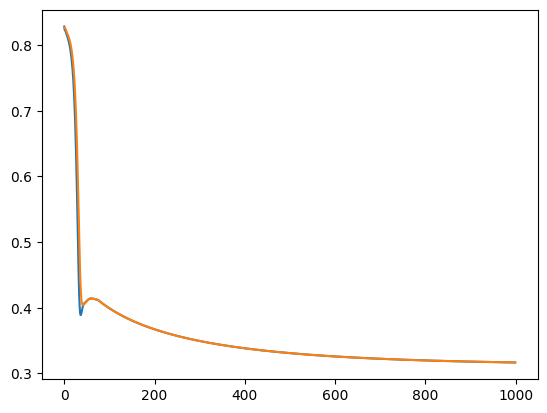

In [15]:
_ = plt.plot(time[:1000], x_matrix_N_sites[:1000, 0])
_ = plt.plot(time[:1000], x_matrix_N_sites[:1000, 90])

# Sincronização

In [10]:
def squared_error(array):
    """This function computes the squared error of an array using the mean as the "truth" value.

    Args:
        array (Array): 2D array containing the values

    Return:
         Return the squared error.
    """
    mean = np.mean(array,axis=1).reshape(len(array),-1)
    diff = array - mean
    return np.sum(diff**2)

def calculate_mean_error(array):
    return squared_error(array)/len(array)

In [11]:
D_x_values = np.arange(0,0.5,0.01)
d = []
for d_x in D_x_values:
    params_N_sites = (5, 0.1, 3.2, 2, 0.4, 0.01, d_x, 0.0, 0.3)
    x_matrix_N_sites, y_matrix_N_sites, z_matrix_N_sites = integrate_N_sites_sytem(
        initial_cond_N_sites, number_of_steps_N_sites, params_N_sites
    )
    d.append(calculate_mean_error(y_matrix_N_sites[5500:,:])+calculate_mean_error(x_matrix_N_sites[5500:,:])+calculate_mean_error(z_matrix_N_sites[5500:,:]))
sincronization = np.exp(-np.array(d))

Text(0, 0.5, '$s$')

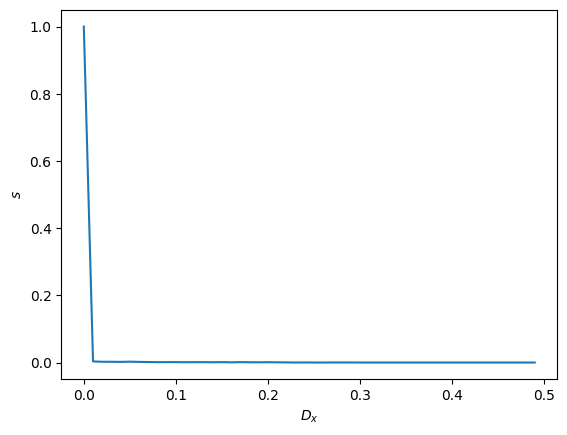

In [12]:
_ = plt.plot(D_x_values,sincronization)
plt.xlabel(r'$D_x$')
plt.ylabel('$s$')

In [14]:
sincronization

array([1.00000000e+00, 3.24398657e-03, 2.26967212e-03, 2.16680674e-03,
       1.90502994e-03, 2.53779200e-03, 1.87945936e-03, 1.50322644e-03,
       1.01713815e-03, 1.15612202e-03, 1.23069429e-03, 8.52573417e-04,
       1.06236637e-03, 1.12204771e-03, 7.71114150e-04, 1.10554817e-03,
       6.11142091e-04, 1.06461203e-03, 7.93960103e-04, 6.23768386e-04,
       8.68679343e-04, 6.24783849e-04, 3.71882984e-04, 4.30200179e-06,
       1.57201077e-04, 4.56383833e-06, 1.39461075e-06, 1.21681745e-04,
       1.33799218e-04, 1.18894954e-04, 2.12200321e-07, 8.36175004e-07,
       8.55235685e-07, 8.71359453e-07, 4.59194959e-07, 1.15421579e-07,
       5.63058685e-08, 2.43452844e-07, 1.20952861e-07, 1.22676365e-07,
       5.91771488e-08, 1.26740609e-08, 2.54035762e-09, 2.39610938e-10,
       6.14289701e-11, 1.84713240e-11, 5.09728152e-11, 1.68415017e-11,
       1.05115816e-11, 7.17918332e-12])